## Setup

In [ ]:
!pip install simpleitk
!pip install --upgrade torchaudio torchdata torchtext
!pip install --upgrade pytorch-ignite
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import time
from tqdm import tqdm
from pprint import pprint

from skimage import io, transform
from collections import OrderedDict

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

from torchvision import models
from torch.nn.functional import relu

import torchvision.transforms as tt
import albumentations as A

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Segmentation using U-net architecture

The dataset contains 3D prostate MR images (in .nii format) together with segmentation masks. They were obtained from Medical Segmentation Decathlon (MSD), a biomedical image analysis challenge [link](https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2).

### Use monai for pre-processing before training

In [ ]:
from glob import glob

import monai

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,ToTensord,Resized,Activations
)

from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

### Define some transformation approaches

In [ ]:
orig_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        ToTensord(keys=['image', 'label']),

     ]
)

train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=["image", "label"]),
        # Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.)),    #adjust the contrast to allow a better visualization
        ScaleIntensityRanged(keys='image', a_min=0, a_max=2751, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Resized(keys=['image', 'label'], spatial_size=[256,256,11]),
        ToTensord(keys=['image', 'label'])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        EnsureChannelFirstd(keys=["image", "label"]),
        # Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.)),
        ScaleIntensityRanged(keys='image', a_min=0, a_max=2751, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=['image', 'label'], spatial_size=[256,256,11]),
        ToTensord(keys=['image', 'label'])
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=['image']),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(keys='image', a_min=0, a_max=2751, b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=['image'], spatial_size=[256,256,11]),
        ToTensord(keys=['image'])
    ]
)

In [ ]:
in_dir = "./Task05_Prostate/"

image_files = sorted(glob(os.path.join(in_dir, "imagesTr", "*.nii.gz")))
mask_files = sorted(glob(os.path.join(in_dir, "labelsTr", "*.nii.gz")))
ts_files = sorted(glob(os.path.join(in_dir, "imagesTs", "*.nii.gz")))

from sklearn.model_selection import train_test_split
path_train_volumes, path_test_volumes,path_train_segmentation,path_test_segmentation = train_test_split(image_files,mask_files, test_size=0.1, random_state=0)

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = [{"image": image_name} for image_name in ts_files]

In [ ]:
print(f"Train shape: {len(train_files)}\nVal shape: {len(val_files)}\nTest shape: {len(test_files)}")

Train shape: 28
Val shape: 4
Test shape: 16


### Get train, validation and test loader

In [ ]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=4)

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=4)

In [ ]:
test_patient = first(train_loader)
orig_patient = first(orig_loader)
print(f"Transform image shape: {test_patient['image'].shape}\n Original image shape: {orig_patient['image'].shape}")

Transform image shape: torch.Size([4, 2, 256, 256, 11])
 Original image shape: torch.Size([1, 384, 384, 11, 2])


### Visualization

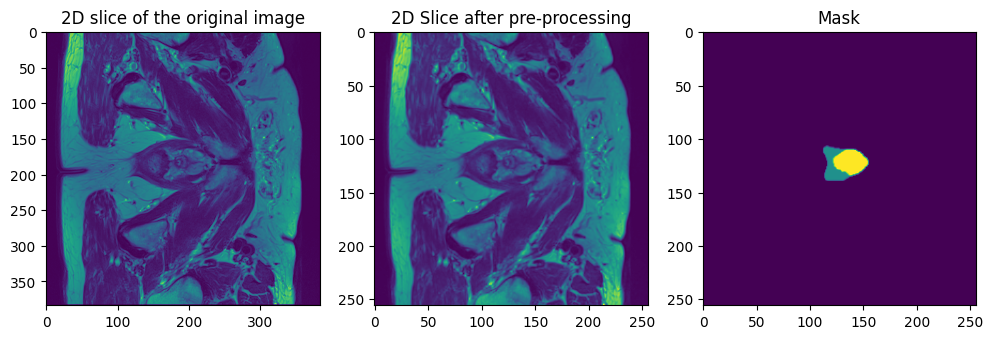

In [ ]:
plt.figure('test', (12, 6))
slice_num = 0
plt.subplot(1, 3, 1)
plt.title('2D slice of the original image')
plt.imshow(orig_patient['image'][0,: ,:,slice_num ,0])

plt.subplot(1, 3, 2)
plt.title('2D Slice after pre-processing')
plt.imshow(test_patient['image'][0,0,: ,: ,slice_num])

plt.subplot(1,3,3)
plt.title('Mask')
plt.imshow(test_patient['label'][0,0,: ,: ,slice_num])
plt.show()

In [ ]:
def create_gif(input_image, title=None, filename=None):

    import matplotlib.animation as animate
    images = []
    input_image_data = input_image
    fig = plt.figure()
    for i in range(len(input_image_data)):
        im = plt.imshow(input_image_data[i],cmap='gray', animated=True)
        images.append([im])

    ani = animate.ArtistAnimation(fig, images, interval=200, blit=True, repeat_delay=1000)
    plt.title(title, fontsize=20)
    plt.axis('off')
    ani.save(filename)
    plt.show()

In [ ]:
create_gif(test_patient['image'].permute(0,1,4,2,3)[0][0], title=None, filename="Prostate_MRI.gif")

### U-net architecture

In [ ]:
class DoubleConv(nn.Module):

    '''
    This block consisting of two convolutional layers with batch normalization and ReLU activation after each convolution
    '''

    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super().__init__()
        if not hidden_channels:
            hidden_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

class Encoder(nn.Module):

    '''
    This class represents the encoder or downscaling block using max pooling followed by a double convolution block
    In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
    '''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Decoder(nn.Module):

    '''
    This class represents the decoder/ upscaling block using transpose convolution, followed by a double convolution block
    In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image.
    To ensure
    '''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):

        '''
        x2 represents the tensor from the encoder (downsampling) path.
        x1  is upsampled to match x2
        To make sure that the spatial dimensions (height and width) of x1 match those of x2, x1 is padded
        After x1 and x2 have the the same H and W, there are concatenation along the channel dimension
        The  values for padding are calculated based on the differences diffY and diffX [left, right, top, bottom]
        '''
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),nn.Softmax(dim=1))
            # nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):

    '''
    Custom class UNet is defined as a subclass of nn.Module.
    The __init__ method initializes the architecture of the U-Net by defining the layers for both the encoder and decoder parts of the network.
    The argument n_classes specifies the number of classes for the segmentation task.
    '''

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Encoder(64, 128)
        self.down2 = Encoder(128, 256)
        self.down3 = Encoder(256, 512)
        self.down4 = Encoder(512, 1024)

        self.up1 = Decoder(1024, 512)
        self.up2 = Decoder(512, 256)
        self.up3 = Decoder(256, 128)
        self.up4 = Decoder(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Loss function

In [ ]:
def dice_coef_metric(pred, label):
    smooth = 1e-8
    pred = torch.argmax(pred,axis=1)
    label = label.type(torch.long)

    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum() +smooth
    return intersection / union

def dice_coef_loss(pred, label):
    return 1 - dice_coef_metric(pred, label)

def bce_dice_loss(pred, label):
    label = label.type(torch.long)
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = F.cross_entropy(pred, label)
    return dice_loss + bce_loss

### Training and validation

In [ ]:
model = UNet(2,3).to(device)

In [ ]:
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 30
train_loss = []
val_loss = []
train_dice = []
val_dice = []
best_val_dice = 0
save_dir = './model/'


for epoch in range(epochs):
    model.train()
    running_train_loss = []
    running_val_loss = []
    running_train_dice = []
    running_val_dice = []


    for batch in tqdm(train_loader):
      images = batch['image'].to(device,dtype=torch.float).permute(0,1,4,2,3) #(batchsize,channels,depth,height,width)
      masks = batch['label'].to(device,dtype=torch.float).permute(0,1,4,2,3)


      for i  in range(images.shape[2]):
        image = images[:,:,i,:,:]
        mask = masks[:,:,i,:,:].squeeze(1)
        outputs = model(image)

        loss = bce_dice_loss(outputs,mask)
        running_train_loss.append(loss.item())

        loss.backward()

        preds = outputs.clone()

        dice_ = dice_coef_metric(preds, mask)
        running_train_dice.append(dice_.item())

        optimizer.step()
        optimizer.zero_grad()



    model.eval()
    with torch.no_grad():
      for batch in val_loader:
        image = batch['image'].to(device,dtype=torch.float).permute(0,1,4,2,3)
        mask = batch['label'].to(device,dtype=torch.float).permute(0,1,4,2,3)

        for i  in range(image.shape[2]):
          img = image[:,:,i,:,:]
          masks = mask[:,:,i,:,:].squeeze(1)
          outputs = model(img)

          loss = bce_dice_loss(outputs,masks)
          running_val_loss.append(loss.item())

          preds = outputs.clone()

          dice = dice_coef_metric(preds, masks)
          running_val_dice.append(dice.item())



    epoch_train_loss = np.mean(running_train_loss)
    print('Train loss for epoch {}: {}'.format(epoch+1, epoch_train_loss))
    train_loss.append(epoch_train_loss)

    epoch_train_dice = np.mean(running_train_dice)
    print('Train dice metric for epoch {}: {}'.format(epoch+1, epoch_train_dice))
    train_dice.append(epoch_train_dice)

    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss for epoch {}: {}'.format(epoch+1, epoch_val_loss))
    val_loss.append(epoch_val_loss)

    epoch_val_dice = np.mean(running_val_dice)
    print('Validation dice metric for epoch {}: {}'.format(epoch+1, epoch_val_dice))
    val_dice.append(epoch_val_dice)

    #save the model if it is the best performing on the eval metric
    if epoch_val_dice>best_val_dice:
      best_val_dice = epoch_val_dice
      print(
            f"Saving new best performing model (dice_coefficient={best_val_dice})."
          )
      checkpoint_name = 'checkpoint_best_MSD.pth'
      checkpoint = {
          'nb_epochs_finished': epoch + 1,
          'model_state': model.state_dict(),
          'optimizer_state': optimizer.state_dict()
      }
      save_path = os.path.join(save_dir, checkpoint_name)
      torch.save(checkpoint, save_path)

100%|██████████| 7/7 [00:28<00:00,  4.03s/it]


Train loss for epoch 1: 1.789445525640017
Train dice metric for epoch 1: 0.24506909533270768
Validation loss for epoch 1: 1.351663421500813
Validation dice metric for epoch 1: 0.5425581810149279
Saving new best performing model (dice_coefficient=0.5425581810149279).


100%|██████████| 7/7 [00:27<00:00,  3.93s/it]


Train loss for epoch 2: 1.5691014311530374
Train dice metric for epoch 2: 0.37211762388031205
Validation loss for epoch 2: 1.2345653718168086
Validation dice metric for epoch 2: 0.6088100319558923
Saving new best performing model (dice_coefficient=0.6088100319558923).


100%|██████████| 7/7 [00:28<00:00,  4.04s/it]


Train loss for epoch 3: 1.41224260454054
Train dice metric for epoch 3: 0.4873517989725262
Validation loss for epoch 3: 1.090818632732738
Validation dice metric for epoch 3: 0.7346971512518146
Saving new best performing model (dice_coefficient=0.7346971512518146).


100%|██████████| 7/7 [00:28<00:00,  4.08s/it]


Train loss for epoch 4: 1.209064014546283
Train dice metric for epoch 4: 0.6647970539263703
Validation loss for epoch 4: 0.8685713464563544
Validation dice metric for epoch 4: 0.9478754699230194
Saving new best performing model (dice_coefficient=0.9478754699230194).


100%|██████████| 7/7 [00:30<00:00,  4.37s/it]


Train loss for epoch 5: 0.9152764267735667
Train dice metric for epoch 5: 0.940355681415115
Validation loss for epoch 5: 0.7242346460169012
Validation dice metric for epoch 5: 1.086571921001781
Saving new best performing model (dice_coefficient=1.086571921001781).


100%|██████████| 7/7 [00:28<00:00,  4.04s/it]


Train loss for epoch 6: 0.7761285606916849
Train dice metric for epoch 6: 1.0675258088808555
Validation loss for epoch 6: 0.887475620616566
Validation dice metric for epoch 6: 0.9193535880608992


100%|██████████| 7/7 [00:27<00:00,  3.97s/it]


Train loss for epoch 7: 0.6970227786472866
Train dice metric for epoch 7: 1.1365561535606137
Validation loss for epoch 7: 0.9059628681703047
Validation dice metric for epoch 7: 0.8915345831350847


100%|██████████| 7/7 [00:27<00:00,  3.96s/it]


Train loss for epoch 8: 0.6123886317401738
Train dice metric for epoch 8: 1.2117273624163944
Validation loss for epoch 8: 0.799028526652943
Validation dice metric for epoch 8: 0.9937108944762837


100%|██████████| 7/7 [00:27<00:00,  3.95s/it]


Train loss for epoch 9: 0.5545676520892552
Train dice metric for epoch 9: 1.260968589163446
Validation loss for epoch 9: 0.7115337144244801
Validation dice metric for epoch 9: 1.0771187327124856


100%|██████████| 7/7 [00:27<00:00,  3.93s/it]


Train loss for epoch 10: 0.516071617603302
Train dice metric for epoch 10: 1.2915652154327988
Validation loss for epoch 10: 0.7106461904265664
Validation dice metric for epoch 10: 1.072352869944139


100%|██████████| 7/7 [00:27<00:00,  4.00s/it]


Train loss for epoch 11: 0.5049413434870831
Train dice metric for epoch 11: 1.2954969989595475
Validation loss for epoch 11: 0.8383734226226807
Validation dice metric for epoch 11: 0.9411955529993231


100%|██████████| 7/7 [00:27<00:00,  4.00s/it]


Train loss for epoch 12: 0.48112665058730486
Train dice metric for epoch 12: 1.3118907826674449
Validation loss for epoch 12: 0.7131145054643805
Validation dice metric for epoch 12: 1.0609158277511597


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Train loss for epoch 13: 0.4381330369354843
Train dice metric for epoch 13: 1.3470211768305147
Validation loss for epoch 13: 0.7056608254259283
Validation dice metric for epoch 13: 1.0636368285525928


100%|██████████| 7/7 [00:27<00:00,  3.99s/it]


Train loss for epoch 14: 0.43607658689672296
Train dice metric for epoch 14: 1.342205722997715
Validation loss for epoch 14: 0.7966419783505526
Validation dice metric for epoch 14: 0.9664068977263841


100%|██████████| 7/7 [00:28<00:00,  4.01s/it]


Train loss for epoch 15: 0.3974421372661343
Train dice metric for epoch 15: 1.3739630129043159
Validation loss for epoch 15: 0.6389683485031128
Validation dice metric for epoch 15: 1.1203523169864307
Saving new best performing model (dice_coefficient=1.1203523169864307).


100%|██████████| 7/7 [00:28<00:00,  4.02s/it]


Train loss for epoch 16: 0.3706660115873659
Train dice metric for epoch 16: 1.394351096509339
Validation loss for epoch 16: 0.7221523035656322
Validation dice metric for epoch 16: 1.0344835357232527


100%|██████████| 7/7 [00:27<00:00,  3.98s/it]


Train loss for epoch 17: 0.35629462731349004
Train dice metric for epoch 17: 1.4025998922524514
Validation loss for epoch 17: 0.6430118083953857
Validation dice metric for epoch 17: 1.1042335792021318


100%|██████████| 7/7 [00:28<00:00,  4.00s/it]


Train loss for epoch 18: 0.3295117090274761
Train dice metric for epoch 18: 1.4231720199058582
Validation loss for epoch 18: 0.5869572758674622
Validation dice metric for epoch 18: 1.15486694465984
Saving new best performing model (dice_coefficient=1.15486694465984).


100%|██████████| 7/7 [00:28<00:00,  4.04s/it]


Train loss for epoch 19: 0.30936548229935884
Train dice metric for epoch 19: 1.4366950224359314
Validation loss for epoch 19: 0.6390313939614729
Validation dice metric for epoch 19: 1.097357067194852


100%|██████████| 7/7 [00:27<00:00,  3.99s/it]


Train loss for epoch 20: 0.30239117842215996
Train dice metric for epoch 20: 1.4382825571221192
Validation loss for epoch 20: 0.7268937013366006
Validation dice metric for epoch 20: 1.0039622031829574


100%|██████████| 7/7 [00:27<00:00,  3.97s/it]


Train loss for epoch 21: 0.2802367976733616
Train dice metric for epoch 21: 1.455335455668437
Validation loss for epoch 21: 0.6427624767476862
Validation dice metric for epoch 21: 1.0844033360481262


100%|██████████| 7/7 [00:27<00:00,  3.94s/it]


Train loss for epoch 22: 0.25337763188721296
Train dice metric for epoch 22: 1.4773096082272468
Validation loss for epoch 22: 0.7528283325108615
Validation dice metric for epoch 22: 0.9701389812610366


100%|██████████| 7/7 [00:27<00:00,  3.93s/it]


Train loss for epoch 23: 0.24947382103313098
Train dice metric for epoch 23: 1.4765239160556298
Validation loss for epoch 23: 0.6063390049067411
Validation dice metric for epoch 23: 1.1136714220046997


100%|██████████| 7/7 [00:27<00:00,  3.97s/it]


Train loss for epoch 24: 0.22613578415536262
Train dice metric for epoch 24: 1.4953271448612213
Validation loss for epoch 24: 0.5405909689989957
Validation dice metric for epoch 24: 1.176357924938202
Saving new best performing model (dice_coefficient=1.176357924938202).


100%|██████████| 7/7 [00:28<00:00,  4.04s/it]


Train loss for epoch 25: 0.215688072241746
Train dice metric for epoch 25: 1.5016438014708555
Validation loss for epoch 25: 0.6533720222386447
Validation dice metric for epoch 25: 1.0597623373297127


100%|██████████| 7/7 [00:27<00:00,  4.00s/it]


Train loss for epoch 26: 0.2049705974467389
Train dice metric for epoch 26: 1.5082231845174516
Validation loss for epoch 26: 0.7500886862928217
Validation dice metric for epoch 26: 0.9586902003396641


100%|██████████| 7/7 [00:27<00:00,  3.98s/it]


Train loss for epoch 27: 0.20830653085337056
Train dice metric for epoch 27: 1.5010138246920202
Validation loss for epoch 27: 0.6718275872143832
Validation dice metric for epoch 27: 1.0330596945502541


100%|██████████| 7/7 [00:27<00:00,  3.98s/it]


Train loss for epoch 28: 0.1823833313855258
Train dice metric for epoch 28: 1.5226529867618115
Validation loss for epoch 28: 0.6733037450096824
Validation dice metric for epoch 28: 1.0283961350267583


100%|██████████| 7/7 [00:27<00:00,  4.00s/it]


Train loss for epoch 29: 0.1745038086717779
Train dice metric for epoch 29: 1.5269604456889165
Validation loss for epoch 29: 0.6966267661614851
Validation dice metric for epoch 29: 1.001996928995306


100%|██████████| 7/7 [00:28<00:00,  4.13s/it]


Train loss for epoch 30: 0.16994838281111282
Train dice metric for epoch 30: 1.5279030370247828
Validation loss for epoch 30: 0.6971710053357211
Validation dice metric for epoch 30: 0.9985217722979459


### Plot losses

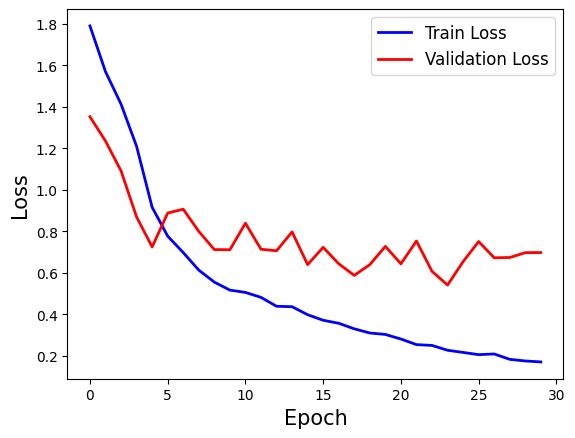

In [ ]:
plt.plot(train_loss, label='Train Loss', lw=2, c="b")
plt.plot(val_loss,label='Validation Loss', lw=2, c="r")
plt.legend(fontsize=12);
plt.xlabel("Epoch", fontsize=15);
plt.ylabel("Loss", fontsize=15);

### Testing and Visualization of some predictions

In [ ]:
#load the best best model saved during the training
save_dir = "./model/"
checkpoint_name = "checkpoint_best_MSD.pth"
PATH = os.path.join(save_dir, checkpoint_name)
state_dict = torch.load(PATH, map_location=torch.device('cpu')) #If using cpu

model = UNet(2,3).to(device)

model.load_state_dict(state_dict['model_state'])
model.eval()

In [ ]:
test_patient = first(val_loader)
slice_num = 5
img = test_patient['image'].to(device,dtype=torch.float).permute(0,1,4,2,3)[:,:,slice_num,:,:]
pred =  model(img)

pred = torch.argmax(pred,axis=1)
print(pred.unique())
pred = pred.detach().cpu().numpy()

tensor([0, 1, 2])


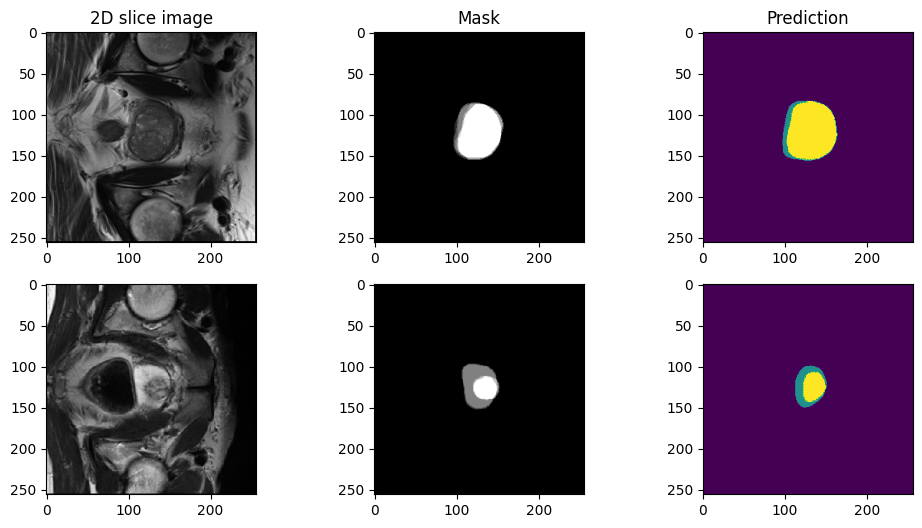

In [ ]:
plt.figure('test', (12, 6))
i = 1

plt.subplot(2, 3, 1)
plt.title('2D slice image')
plt.imshow(test_patient['image'].permute(0,1,4,2,3)[i,0, slice_num,: ,:], cmap='gray')

plt.subplot(2,3,2)
plt.title('Mask')
plt.imshow(test_patient['label'].permute(0,1,4,2,3)[i,0, slice_num,: ,:],cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Prediction')
plt.imshow(pred[i])

plt.subplot(2, 3, 4)
plt.imshow(test_patient['image'].permute(0,1,4,2,3)[i+1,0, slice_num,: ,:], cmap='gray')

plt.subplot(2,3,5)
plt.imshow(test_patient['label'].permute(0,1,4,2,3)[i+1,0, slice_num,: ,:], cmap='gray')

plt.subplot(2, 3, 6)
plt.imshow(pred[i+1])
# plt.show()

#### Create mask for the test sample

In [ ]:
pred_masks=[]
images = []
model.eval()
running_test_loss=[]

for batch in tqdm(test_loader):

  image = batch['image'].to(device,dtype=torch.float).permute(0,1,4,2,3)

  for i  in range(image.shape[2]):
    img = image[:,:,i,:,:]
    outputs = model(img)

    preds = outputs.clone()
    preds = torch.argmax(preds,axis=1)
    preds = preds.detach().cpu().numpy()
    pred_masks.append(preds)
    images.append(img.detach().cpu().numpy())

100%|██████████| 4/4 [06:58<00:00, 104.59s/it]


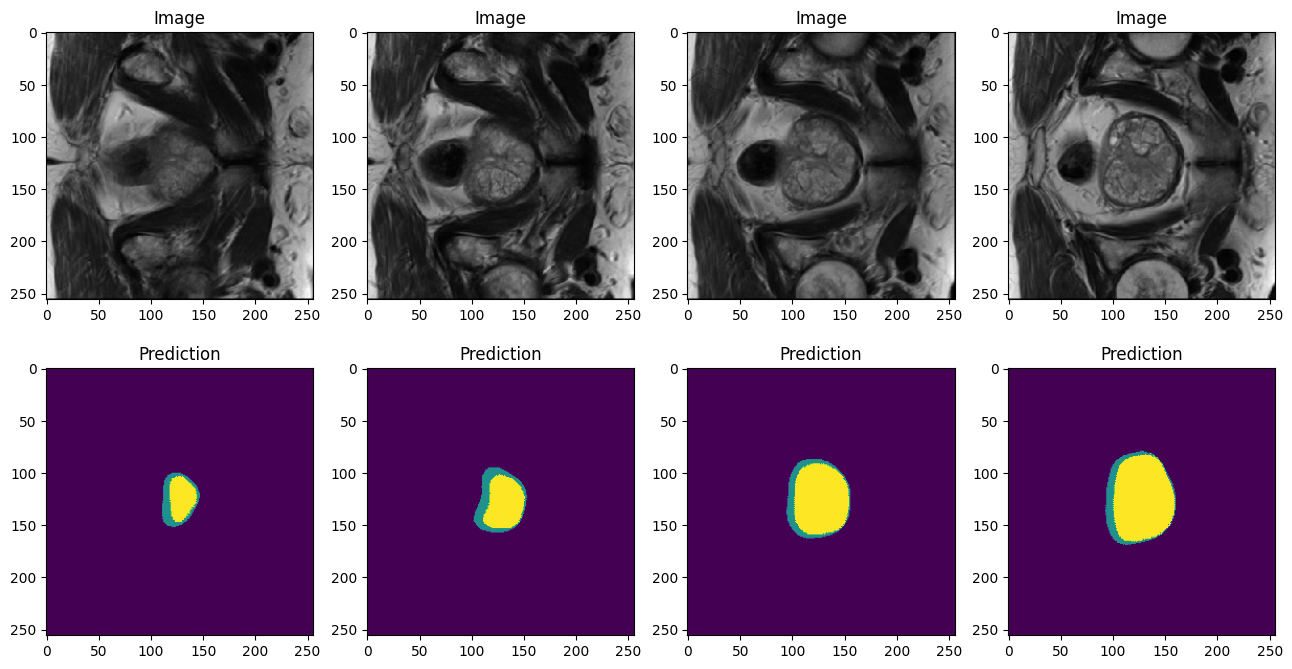

In [ ]:
plt.figure('test', (20, 8))
n=5
j = 3
for i in range(1,n):
  plt.subplot(2, n, i)
  plt.title('Image')
  plt.imshow(images[i][j,0,:,:], cmap='gray')

  plt.subplot(2, n, n+i)
  plt.title('Prediction')
  plt.imshow(pred_masks[i][j])